In [1]:
# Import libraries
import pickle
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

print("✅ Libraries imported")

✅ Libraries imported


In [2]:
# Load the prepared data
with open('../data/prepared_data.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

print(f"✅ Data loaded!")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

✅ Data loaded!
Training samples: 152,525
Test samples: 38,132


In [5]:
# Clean up data types
import pandas as pd

print("Cleaning data types...")

# Replace empty strings with NaN
X_train = X_train.replace('', np.nan)
X_test = X_test.replace('', np.nan)

# Convert everything to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN
mask_train = ~X_train.isnull().any(axis=1)
mask_test = ~X_test.isnull().any(axis=1)

X_train = X_train[mask_train]
y_train = y_train[mask_train]
X_test = X_test[mask_test]
y_test = y_test[mask_test]

print(f"✅ Data cleaned!")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

Cleaning data types...
✅ Data cleaned!
Training samples: 149,516
Test samples: 37,381


In [7]:
# Train XGBoost model
print("Training XGBoost...")
print("(30-60 seconds)\n")

xgb_model = xgb.XGBRegressor(
    n_estimators=100,       # 100 trees
    max_depth=10,           # Tree depth
    learning_rate=0.1,      # How fast it learns
    random_state=42,
    n_jobs=-1,              # Use all CPU cores
    verbosity=1
)

xgb_model.fit(X_train, y_train)

print("\n✅ Training complete")

Training XGBoost...
(30-60 seconds)


✅ Training complete


In [8]:
# Make predictions on test set
y_pred = xgb_model.predict(X_test)

print("✅ Predictions made")
print(f"\nPredicted {len(y_pred):,} option prices")

✅ Predictions made

Predicted 37,381 option prices


In [9]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("="*60)
print("XGBOOST RESULTS")
print("="*60)
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Error (MAE):      ${mae:.2f}")
print(f"R² Score:                       {r2:.4f}")
print("="*60)
print("\nWhat this means:")
print(f"  • On average, predictions are off by ${mae:.2f}")
print(f"  • Model explains {r2*100:.2f}% of price variance")
print(f"  • {'EXCELLENT' if r2 > 0.95 else 'GOOD' if r2 > 0.85 else 'DECENT'} performance!")
print("\nComparison to Random Forest:")
print(f"  • Random Forest R²: 0.9963 (MAE: $1.60)")
print(f"  • XGBoost R²: {r2:.4f} (MAE: ${mae:.2f})")

XGBOOST RESULTS
Root Mean Squared Error (RMSE): $3.61
Mean Absolute Error (MAE):      $1.85
R² Score:                       0.9954

What this means:
  • On average, predictions are off by $1.85
  • Model explains 99.54% of price variance
  • EXCELLENT performance!

Comparison to Random Forest:
  • Random Forest R²: 0.9963 (MAE: $1.60)
  • XGBoost R²: 0.9954 (MAE: $1.85)


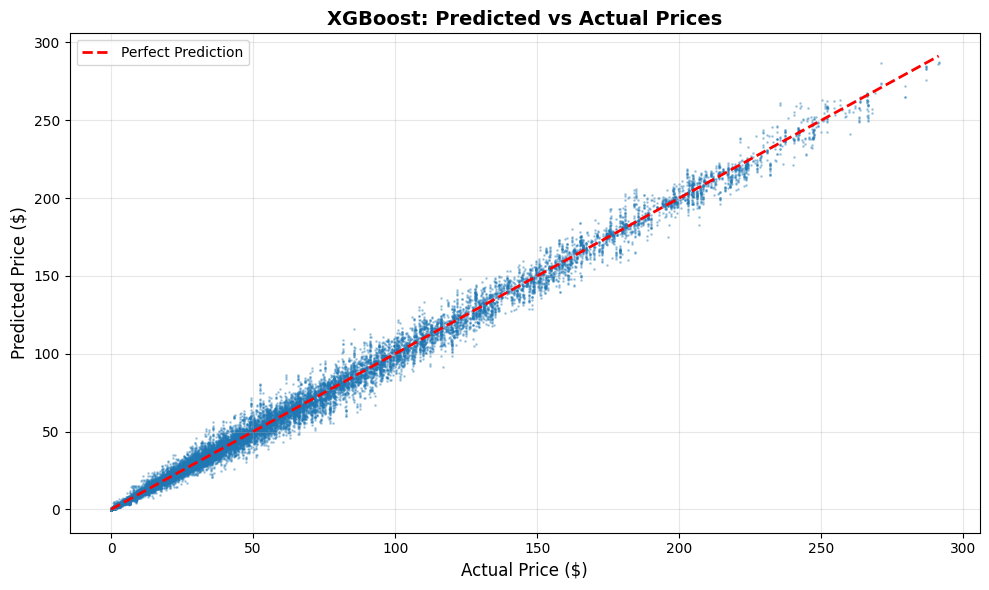

The closer points are to the red line, the better!


In [10]:
# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, s=1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price ($)', fontsize=12)
plt.title('XGBoost: Predicted vs Actual Prices', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("The closer points are to the red line, the better!")


Feature Importance (which inputs matter most):
1. STRIKE               88.00%
2. C_GAMMA               5.20%
3. C_DELTA               4.20%
4. DTE                   1.56%
5. C_VEGA                0.57%
6. C_IV                  0.20%
7. UNDERLYING_LAST       0.17%
8. C_THETA               0.11%


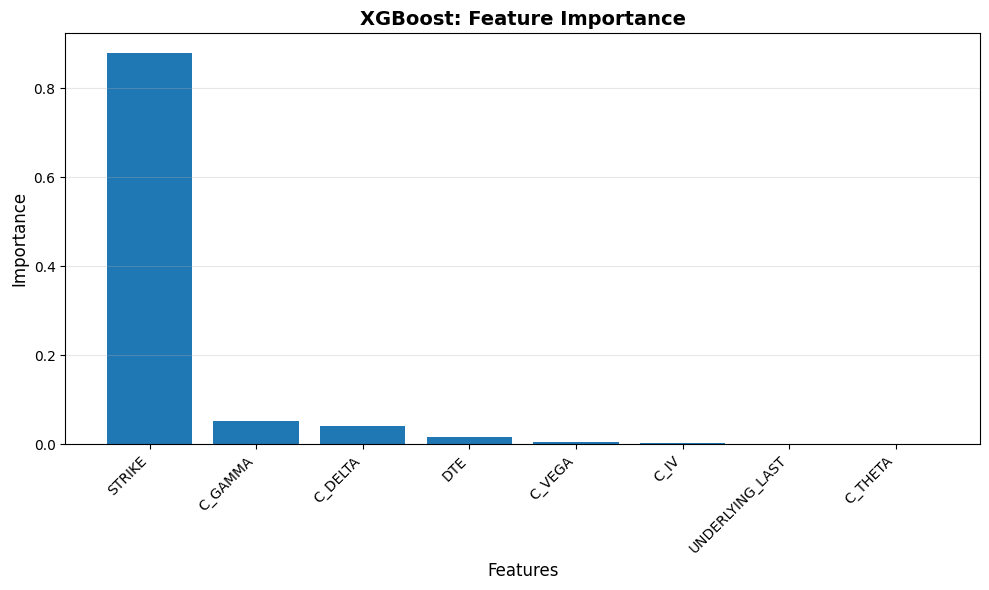

In [11]:
# Feature importance
feature_names = X_train.columns
importances = xgb_model.feature_importances_

# Sort by importance
indices = np.argsort(importances)[::-1]

print("\nFeature Importance (which inputs matter most):")
print("="*60)
for i in range(len(feature_names)):
    print(f"{i+1}. {feature_names[indices[i]]:20s} {importances[indices[i]]*100:5.2f}%")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('XGBoost: Feature Importance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Save the model (though we won't push it to GitHub - too large)
with open('../data/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("✅ Model saved to 'data/xgb_model.pkl'")
print("\n🎉 XGBoost model complete!")
print("\nNext: Build Neural Network model")